# SLA-Analysis
### Royer Ticse Torres, July 2019


This notebook is a SLA-analysis in python step-by-step. Starting from raw data to making prediction model on the "ticket_cientista" dataset.

![title](sla1.png "Header")



# Dive into data
First things first!. Understand the content of the data

In [14]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from datetime import datetime
from dateutil.parser import parse
import seaborn as sb
import scipy
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression


import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

In [2]:
address = 'dataset/ticket_cientista.csv'
df = pd.read_csv(address , sep=';')
df['datetime'] = pd.to_datetime(df['currentDateTime'], format='ISODate("%Y-%m-%dT%H:%M:%S.000%z")')
df['datetime'] = pd.to_datetime(df['datetime'], utc='True')

df = df.set_index('datetime')

df.index = df.index.tz_convert(None)
df.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (25,35,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,attendanceType,attendanceTypeId,averageRepairTime,averageRepairTimeType,averageServiceTime,averageSolutionTime,averageWaitingTimeType,callBranch,callBranchName,callCloseDate,...,repairTimeEngineer,schedulingDate,schedulingDateTime,schedulingTime,segmentId,siteCity,siteName,siteState,slaStatus,type
datetime,,,,,,,,,,,,,,,,,,,,,
2018-02-07 18:49:02,1,5,0,35.0,222,222,52.0,86,Natal,NaN,...,0.0,20180207,"ISODate(""2018-02-07T15:00:00.000-02:00"")",15:00,35,CAICÓ,LEXBRA000010380,RN,NaN,U
2019-02-22 16:03:17,0,2,164,27.0,131,295,66.0,52,Campinas,20190222.0,...,164.0,NaN,NaN,NaN,35,PIRACICABA,LEXMARK00013169,SP,N,U
2019-02-22 15:11:45,0,2,19,27.0,264,283,66.0,52,Campinas,20190222.0,...,19.0,NaN,NaN,NaN,35,JUNDIAI,LEXMARK00013402,SP,N,U
2019-02-26 15:53:54,0,2,360,56.0,257,617,67.0,70,Paissandu,NaN,...,0.0,NaN,NaN,NaN,35,SAO PAULO,LEXMARK00004162,SP,S,U
2019-02-26 15:31:44,0,2,63,21.0,146,209,55.0,AD,Campo Grande,NaN,...,0.0,NaN,NaN,NaN,35,CAMPO GRANDE,LEXMARK00012469,MS,N,U


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43301 entries, 2018-02-07 18:49:02 to 2019-01-02 13:59:05
Data columns (total 44 columns):
attendanceType            43301 non-null int64
attendanceTypeId          43301 non-null int64
averageRepairTime         43301 non-null int64
averageRepairTimeType     43298 non-null float64
averageServiceTime        43301 non-null int64
averageSolutionTime       43301 non-null int64
averageWaitingTimeType    43298 non-null float64
callBranch                43301 non-null object
callBranchName            43301 non-null object
callCloseDate             38856 non-null float64
callCloseTime             38856 non-null object
callNumber                43301 non-null int64
callOpenDate              43301 non-null int64
callOpenTime              43301 non-null object
callRegion                43289 non-null float64
callRegional              43301 non-null object
callRegionalName          43301 non-null object
callRegionName            32676 non-null ob

In [4]:
df_times = df[['openDateTime', 'deadlineDateTime']]
df_times = df_times.dropna()
df_times = df_times.loc[(df_times.index >'2019-01-01')]
df_times = df_times.sort_index()
df_times.head()


,openDateTime,deadlineDateTime
datetime,,
2019-01-01 13:43:43,"ISODate(""2018-12-31T16:17:00.000-02:00"")","ISODate(""2019-01-07T14:18:00.000-02:00"")"
2019-01-01 15:40:19,"ISODate(""2019-01-01T10:48:00.000-02:00"")","ISODate(""2019-01-02T15:48:00.000-02:00"")"
2019-01-01 16:44:52,"ISODate(""2018-12-31T20:04:00.000-02:00"")","ISODate(""2019-01-02T17:00:00.000-02:00"")"
2019-01-01 18:24:56,"ISODate(""2019-01-01T09:54:00.000-02:00"")","ISODate(""2019-01-02T14:54:00.000-02:00"")"
2019-01-01 19:11:29,"ISODate(""2018-12-31T20:09:00.000-02:00"")","ISODate(""2019-01-02T17:00:00.000-02:00"")"


In [5]:
df_deadline = df_times.sample(n=3200,random_state=97, axis=0)

df_deadline["openDateTime_utc"] = pd.to_datetime(df_deadline['openDateTime'], format='ISODate("%Y-%m-%dT%H:%M:%S.000%z")',errors='ignore')
df_deadline["openDateTime_utc"] = pd.to_datetime(df_deadline['openDateTime_utc'], utc='True')
df_deadline["deadlineDateTime_utc"] = pd.to_datetime(df_deadline['deadlineDateTime'], format='ISODate("%Y-%m-%dT%H:%M:%S.000%z")')
df_deadline["deadlineDateTime_utc"] = pd.to_datetime(df_deadline['deadlineDateTime_utc'], utc='True')

df_deadline["deadline"] = df_deadline["deadlineDateTime_utc"] - df_deadline["openDateTime_utc"] 
df_deadline["deadline"].mean()

Timedelta('4 days 02:49:14.568750')

In [7]:
df_deadline["deadline"].median()

Timedelta('2 days 13:58:30')

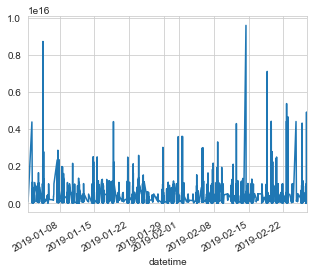

In [15]:
df_deadline["deadline"].plot()

# What data tell us?
* Mean deadline for a call is ~4 days however we can see outliers.
* ?


Since it is essential to prevent SLA violations as much as possible to enhance customer satisfaction and avoid penalty payments. The proposed model will run in a 2-day period so that the manager can make decisions based on the predictions for the next two days. The prediction model is based on machine learning regression techniques and trained using historical process instances.

In [16]:
def dateList(start_date, end_date):
    dateList =[]
    daterange = pd.date_range(start_date, end_date)
    for single_date in daterange:
        dateList.append(single_date.strftime("%Y-%m-%d"))
    return dateList

In [17]:
def data_calls2_onTime(df, str_days):

    pdList = []
    for i in range(0,len(str_days),2):
        df_day = pd.DataFrame()
        df_day = df.loc[str_days[i]:str_days[i+1]]
        df_day = df_day[(df_day["onTimeSolution"] =='S')]
        df_day = df_day['customerCode'].value_counts()
        df_day.name = "Day_"+str(i+1)
        pdList.append(df_day) 
    df_combined = pd.concat(pdList, axis =1)
    df_combined = df_combined.fillna(0)
    return df_combined

In [18]:
def data_calls2(df, str_days):

    pdList = []
    for i in range(0,len(str_days),2):
        df_day = pd.DataFrame()
        df_day = df.loc[str_days[i]:str_days[i+1]]
        df_day = df_day['customerCode'].value_counts()
        df_day.name = "Day_"+str(i+1)
        pdList.append(df_day) 
    df_combined = pd.concat(pdList, axis =1)
    return df_combined

In [22]:
start_date = '2019-01-01'
end_date   = '2019-01-30'

JanDays = dateList(start_date, end_date)

In [23]:
raw_calls = data_calls2(df, JanDays )
raw_calls = raw_calls.fillna(0)
#raw_calls = raw_calls.reset_index()
raw_calls

,Day_1,Day_3,Day_5,Day_7,Day_9,Day_11,Day_13,Day_15,Day_17,Day_19,Day_21,Day_23,Day_25,Day_27,Day_29
215,179.0,321.0,24.0,356.0,383.0,198,273,425,477,42.0,384,388,226,219.0,399
2581,21.0,70.0,0.0,49.0,38.0,30,13,30,77,0.0,57,39,17,14.0,40
3363,131.0,257.0,13.0,251.0,248.0,164,185,261,267,19.0,333,260,112,166.0,309
8068,74.0,209.0,9.0,159.0,187.0,89,105,198,236,7.0,197,171,113,103.0,221
39159,0.0,3.0,2.0,17.0,28.0,10,25,54,47,3.0,40,68,23,34.0,41
87520,86.0,255.0,122.0,249.0,264.0,250,104,229,200,103.0,202,295,209,144.0,232
372301,248.0,574.0,212.0,503.0,563.0,472,317,588,680,227.0,587,650,417,354.0,636
797391,0.0,0.0,0.0,0.0,0.0,1,3,3,4,0.0,2,1,1,0.0,2
900995,1.0,9.0,0.0,10.0,5.0,5,2,24,9,1.0,7,9,8,2.0,11


Text(0, 0.5, 'Calls')

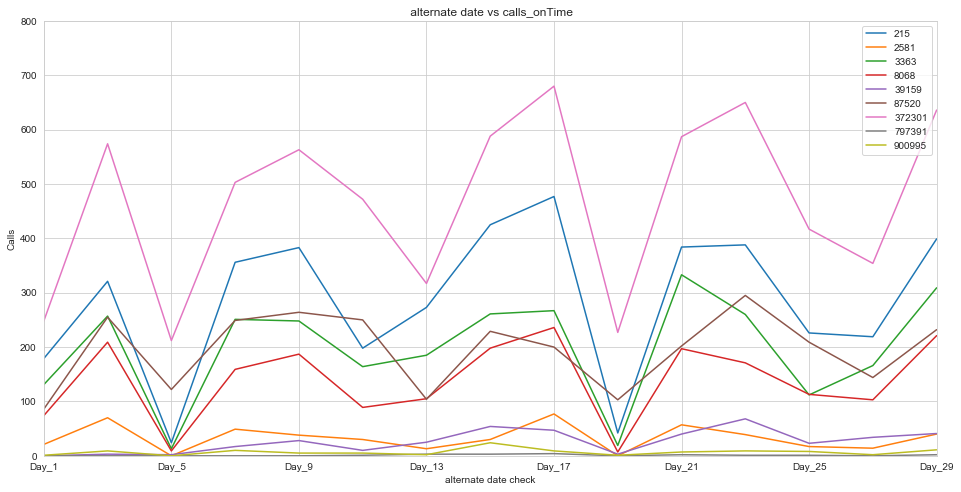

In [25]:
raw_calls_T = raw_calls.T
raw_calls_T.plot(title=' alternate date vs calls_onTime', figsize=(16,8),
                 ylim=(0,800))
plt.xlabel('alternate date check')
plt.ylabel('Calls')

In [27]:
calls_onTime = data_calls2_onTime(df, JanDays )
calls_onTime = calls_onTime.fillna(0)
#calls_onTime = calls_onTime.reset_index()
calls_onTime

,Day_1,Day_3,Day_5,Day_7,Day_9,Day_11,Day_13,Day_15,Day_17,Day_19,Day_21,Day_23,Day_25,Day_27,Day_29
215,136.0,271.0,19.0,305.0,296.0,141,180,345,364,32.0,297,303.0,185,178.0,313
2581,20.0,65.0,0.0,49.0,36.0,28,12,24,74,0.0,48,35.0,16,14.0,37
3363,125.0,247.0,13.0,243.0,234.0,160,178,250,257,19.0,312,245.0,110,160.0,297
8068,28.0,95.0,9.0,77.0,77.0,24,47,82,127,5.0,81,59.0,60,48.0,101
39159,0.0,3.0,2.0,16.0,26.0,10,21,41,39,2.0,31,56.0,18,30.0,33
87520,61.0,182.0,104.0,183.0,188.0,187,84,164,133,92.0,139,197.0,150,119.0,169
372301,161.0,375.0,142.0,355.0,381.0,289,223,379,483,148.0,371,420.0,264,236.0,392
797391,0.0,0.0,0.0,0.0,0.0,1,3,3,4,0.0,2,0.0,1,0.0,2
900995,1.0,7.0,0.0,10.0,5.0,3,2,21,9,1.0,5,6.0,3,1.0,9


Text(0, 0.5, 'Calls')

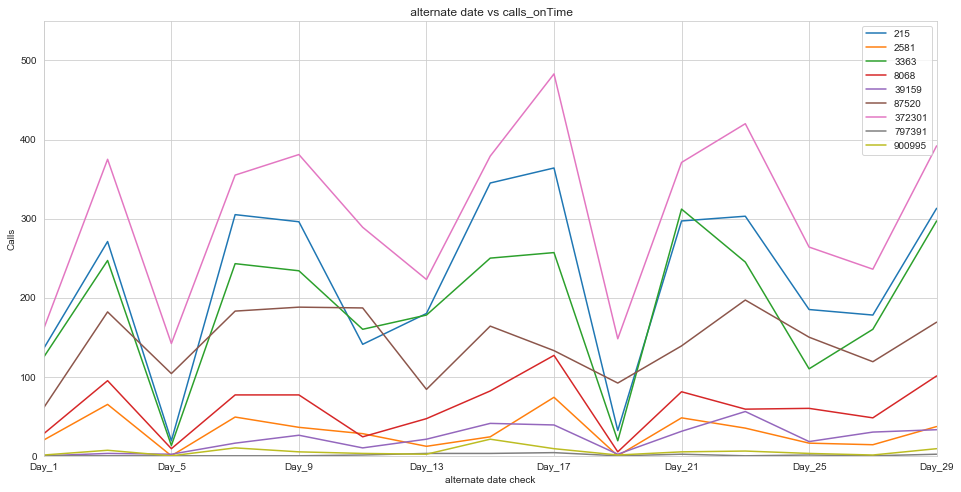

In [28]:
calls_onTime_T = calls_onTime.T

calls_onTime_T.plot(title=' alternate date vs calls_onTime', figsize=(16,8),
                 ylim=(0,550))
plt.xlabel('alternate date check')
plt.ylabel('Calls')

In [30]:
raw_calls = raw_calls.reset_index()
melt = raw_calls.melt(id_vars='index', var_name='Days', value_name='Calls')
melt['Days'] = melt['Days'].str.extract('(\d+)', expand=False).astype(int)

melt = melt.sort_values(['Days', 'index'])
melt.head()

,index,Days,Calls
0,215,0,0.0
1,2581,0,1.0
2,3363,0,2.0
3,8068,0,3.0
4,39159,0,4.0


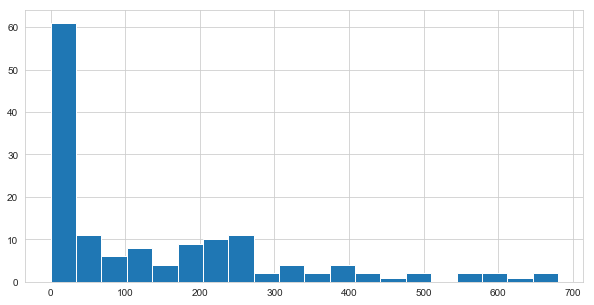

In [31]:
melt['Calls'].hist(bins=20, figsize=(10,5))

In [32]:
melt4 = melt.copy()
melt4['Last_Day_Calls'] = melt4.groupby(['index'])['Calls'].shift()
melt4['Last_Day_Diff'] = melt4.groupby(['index'])['Last_Day_Calls'].diff()
melt4['before_Last_Day_Calls'] = melt4.groupby(['index'])['Calls'].shift(2)
melt4['before_Last_Day_Diff'] = melt4.groupby(['index'])['before_Last_Day_Calls'].diff()
melt4['before-2_Last_Day_Calls'] = melt4.groupby(['index'])['Calls'].shift(3)
melt4['before-2_Last_Day_Diff'] = melt4.groupby(['index'])['before-2_Last_Day_Calls'].diff()
melt4 = melt4.dropna()
melt4.head()

,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,7,356.0,24.0,-297.0,321.0,142.0,179.0,179.0
37,2581,7,49.0,0.0,-70.0,70.0,49.0,21.0,20.0
38,3363,7,251.0,13.0,-244.0,257.0,126.0,131.0,129.0
39,8068,7,159.0,9.0,-200.0,209.0,135.0,74.0,71.0
40,39159,7,17.0,2.0,-1.0,3.0,3.0,0.0,-4.0


In [34]:
calls_onTime = calls_onTime.reset_index()
melt_onTime = calls_onTime.melt(id_vars='index', var_name='Day', value_name='Calls')
melt_onTime['Day'] = melt_onTime['Day'].str.extract('(\d+)', expand=False).astype(int)

melt_onTime = melt_onTime.sort_values(['Day', 'index'])
melt_onTime.head()

,index,Day,Calls
0,215,1,136.0
1,2581,1,20.0
2,3363,1,125.0
3,8068,1,28.0
4,39159,1,0.0


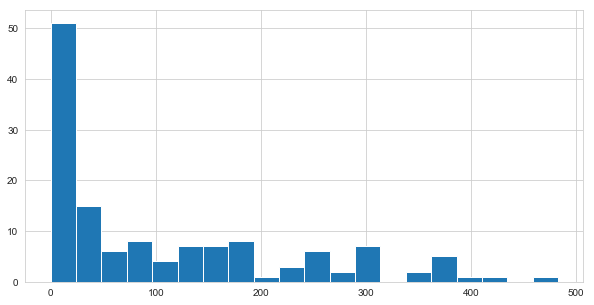

In [35]:
melt_onTime['Calls'].hist(bins=20, figsize=(10,5))

In [36]:
melt4_onTime = melt_onTime.copy()
melt4_onTime['Last_Day_Calls'] = melt4_onTime.groupby(['index'])['Calls'].shift()
melt4_onTime['Last_Day_Diff'] = melt4_onTime.groupby(['index'])['Last_Day_Calls'].diff()
melt4_onTime['before_Last_Day_Calls'] = melt4_onTime.groupby(['index'])['Calls'].shift(2)
melt4_onTime['before_Last_Day_Diff'] = melt4_onTime.groupby(['index'])['before_Last_Day_Calls'].diff()
melt4_onTime['before-2_Last_Day_Calls'] = melt4_onTime.groupby(['index'])['Calls'].shift(3)
melt4_onTime['before-2_Last_Day_Diff'] = melt4_onTime.groupby(['index'])['before-2_Last_Day_Calls'].diff()
melt4_onTime = melt4_onTime.dropna()
melt4_onTime.head()

,index,Day,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,9,296.0,305.0,286.0,19.0,-252.0,271.0,135.0
37,2581,9,36.0,49.0,49.0,0.0,-65.0,65.0,45.0
38,3363,9,234.0,243.0,230.0,13.0,-234.0,247.0,122.0
39,8068,9,77.0,77.0,68.0,9.0,-86.0,95.0,67.0
40,39159,9,26.0,16.0,14.0,2.0,-1.0,3.0,3.0


# Making predictive model

In [37]:
from sklearn.metrics import mean_squared_error
def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

In [38]:
mean_error = []
for day in range(21,29,2):
    train = melt4[melt4['Days'] < day]
    val = melt4[melt4['Days'] == day]
    
    xtr, xts = train.drop(['Calls'], axis=1), val.drop(['Calls'], axis=1)
    ytr, yts = train['Calls'].values, val['Calls'].values
    
    #mdl = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmse(yts, p)
    print('alternate day check %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

alternate day check 21 - Error 116.01427
alternate day check 23 - Error 52.19153
alternate day check 25 - Error 36.06715
alternate day check 27 - Error 76.67820
Mean Error = 70.23778


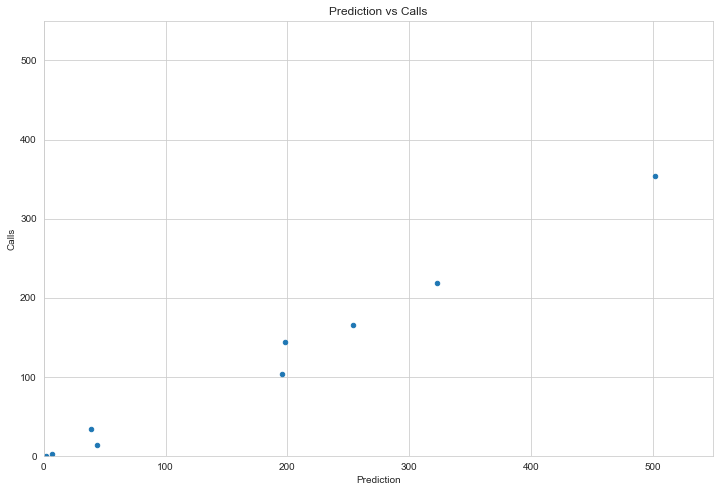

In [41]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Calls', figsize=(12,8), title='Prediction vs Calls', 
                 ylim=(0,550), xlim=(0,550))

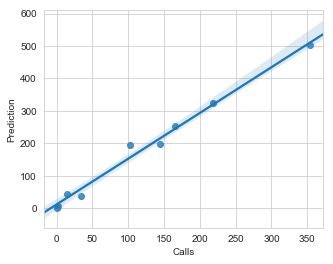

In [42]:
sb.regplot(val["Calls"], val["Prediction"], scatter=True)

In [43]:
mean_error = []
for day in range(21,29,2):
    train = melt4_onTime[melt4_onTime['Day'] < day]
    val = melt4_onTime[melt4_onTime['Day'] == day]
    
    xtr, xts = train.drop(['Calls'], axis=1), val.drop(['Calls'], axis=1)
    ytr, yts = train['Calls'].values, val['Calls'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    #mdl = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmse(yts, p)
    print('alternate day check %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

alternate day check 21 - Error 104.42996
alternate day check 23 - Error 35.17792
alternate day check 25 - Error 25.77549
alternate day check 27 - Error 40.62743
Mean Error = 51.50270


/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


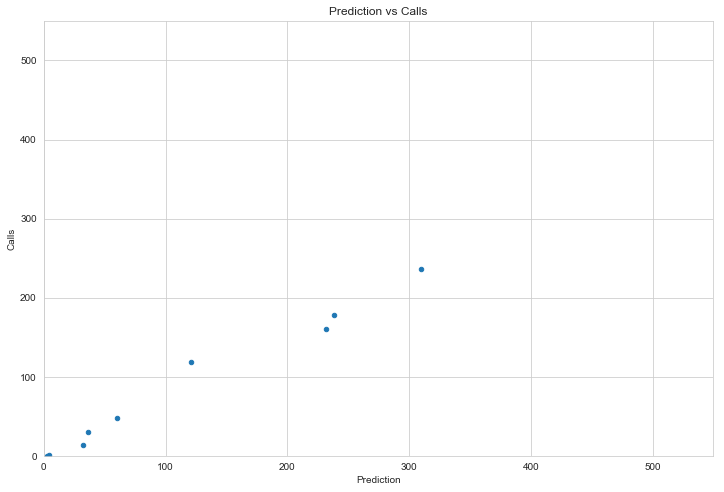

In [44]:
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='Calls', figsize=(12,8), title='Prediction vs Calls', 
                 ylim=(0,550), xlim=(0,550))

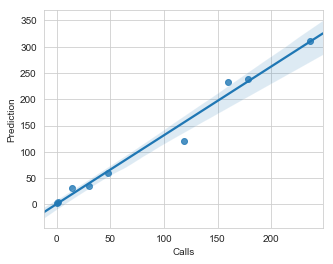

In [45]:
sb.regplot(val["Calls"], val["Prediction"], scatter=True)

# Make predictions and submission

In [47]:
start_date = '2019-02-01'
end_date   = '2019-02-25'
FebDays = dateList(start_date, end_date)

In [52]:
def melting_data(df):
    df = df.reset_index()
    df = df.melt(id_vars='index', var_name='Days', value_name='Calls')
    df['Days'] = df['Days'].str.extract('(\d+)', expand=False).astype(int)
    df = df.sort_values(['Days', 'index'])
    return df

In [53]:
def adding_features(df):
    #melt4 = melt.copy()
    df['Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift()
    df['Last_Day_Diff'] = df.groupby(['index'])['Last_Day_Calls'].diff()
    df['before_Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift(2)
    df['before_Last_Day_Diff'] = df.groupby(['index'])['before_Last_Day_Calls'].diff()
    df['before-2_Last_Day_Calls'] = df.groupby(['index'])['Calls'].shift(3)
    df['before-2_Last_Day_Diff'] = df.groupby(['index'])['before-2_Last_Day_Calls'].diff()
    df= df.dropna()
    return df

In [55]:
raw_calls_Feb = data_calls2(df, JanDays )
raw_calls_Feb = raw_calls_Feb.fillna(0)

data_Feb = melting_data(raw_calls_Feb)

data_Feb = adding_features(data_Feb)

data_Feb.head()


,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,9,383.0,356.0,332.0,24.0,-297.0,321.0,142.0
37,2581,9,38.0,49.0,49.0,0.0,-70.0,70.0,49.0
38,3363,9,248.0,251.0,238.0,13.0,-244.0,257.0,126.0
39,8068,9,187.0,159.0,150.0,9.0,-200.0,209.0,135.0
40,39159,9,28.0,17.0,15.0,2.0,-1.0,3.0,3.0


In [57]:
calls_onTime_Feb = data_calls2_onTime(df, JanDays )
calls_onTime_Feb = calls_onTime.fillna(0)

data_calls_onTime_Feb = melting_data(calls_onTime_Feb)

data_calls_onTime_Feb = adding_features(data_calls_onTime_Feb)

data_calls_onTime_Feb.head()

,index,Days,Calls,Last_Day_Calls,Last_Day_Diff,before_Last_Day_Calls,before_Last_Day_Diff,before-2_Last_Day_Calls,before-2_Last_Day_Diff
36,215,7,305.0,19.0,-252.0,271.0,135.0,136.0,136.0
37,2581,7,49.0,0.0,-65.0,65.0,45.0,20.0,19.0
38,3363,7,243.0,13.0,-234.0,247.0,122.0,125.0,123.0
39,8068,7,77.0,9.0,-86.0,95.0,67.0,28.0,25.0
40,39159,7,16.0,2.0,-1.0,3.0,3.0,0.0,-4.0
